In [1]:
import keras
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.layers import Conv2D,MaxPool2D,GlobalAveragePooling2D,AveragePooling2D
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.utils import np_utils

from tensorflow.keras.layers import BatchNormalization
from keras.regularizers import l2
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
batch_size = 128
epochs = 5
num_classes = 10
weight_decay = 1e-6
nets = 15

In [3]:
train = pd.read_csv('C:/pythonwork/input/train.csv')
test = pd.read_csv('C:/pythonwork/input/test.csv')

In [4]:
labels = train['label']
train = train.drop(['label'],axis=1)
X = train.values
test = test.values

In [5]:
print(X.shape)
print(labels.shape)
print(test.shape)

(42000, 784)
(42000,)
(28000, 784)


In [6]:
X = X/255.
test = test/255.
X = np.reshape(X,(-1,28,28,1))
test = np.reshape(test,(-1,28,28,1))
labels = np_utils.to_categorical(labels,10)
#labels = keras.utils.to_categorical(labels,10)

In [7]:
print(X.shape)
print(test.shape)
print(labels.shape)

(42000, 28, 28, 1)
(28000, 28, 28, 1)
(42000, 10)


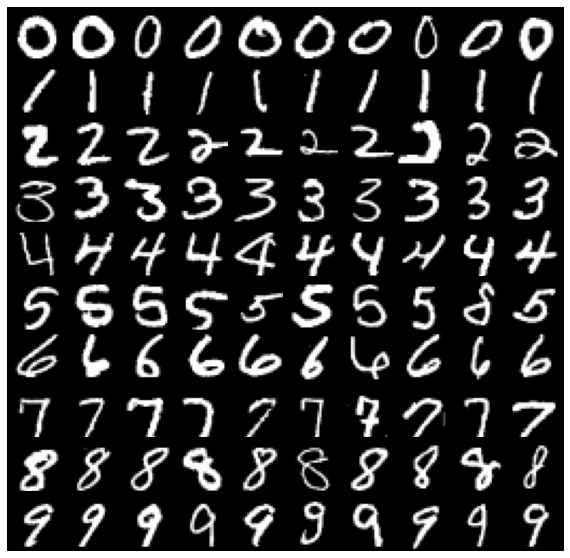

In [8]:
plt.figure(figsize=(10,10))
for i in range(10):
    for j in range(10):
        plt.subplot(10,10,i*10+j+1)
        plt.imshow(X[np.argmax(labels,axis=1)==i][j].reshape(28,28),cmap=plt.cm.gray)
        plt.axis('off')
plt.subplots_adjust(wspace=-0.1,hspace=-0.1)
plt.show()    

In [9]:
learning_rate_reduction = ReduceLROnPlateau(monitor='loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_delta=1e-5)
earlystopping = EarlyStopping(monitor='val_loss',
                              patience=3,
                              verbose=1,
                              mode='auto')

In [10]:
def build_model():
    model = Sequential()
    
    model.add(Conv2D(192,(5,5),padding='same',kernel_regularizer=l2(weight_decay),
                     kernel_initializer='he_normal',input_shape=(28,28,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(160,(1,1),padding='same',kernel_regularizer=l2(weight_decay),kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(96,(1,1),padding='same',kernel_regularizer=l2(weight_decay),kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(3,3),strides=(2,2),padding='same'))
    
    model.add(Dropout(0.2))
    
    model.add(Conv2D(192,(5,5),padding='same',kernel_regularizer=l2(weight_decay),kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(192,(1,1),padding='same',kernel_regularizer=l2(weight_decay),kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(192,(1,1),padding='same',kernel_regularizer=l2(weight_decay),kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(3,3),strides=(2,2),padding='same'))
    
    model.add(Dropout(0.2))
    
    model.add(Conv2D(192,(3,3),padding='same',kernel_regularizer=l2(weight_decay),kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(192,(1,1),padding='same',kernel_regularizer=l2(weight_decay),kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(10,(1,1),padding='same',kernel_regularizer=l2(weight_decay),kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))  
    
    model.add(GlobalAveragePooling2D())
    model.add(Activation('softmax'))
    
    #adam = optimizers.rmsprop()
    from tensorflow.keras import optimizers
    adam = optimizers.RMSprop()
    model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
    return model

In [11]:
models = []
for i in range(nets):
    models.append(build_model())

In [12]:
print('Using real-time data augmentation.')
datagen = ImageDataGenerator(horizontal_flip=False,
                             width_shift_range=0.10,
                             height_shift_range=0.10,
                             fill_mode='constant',
                             cval=0,
                             rotation_range=10,
                             zoom_range=0.1)
histories = []
for i in range(nets):
    x_train,x_valid,y_train,y_valid = train_test_split(X,labels,test_size=0.2)
    datagen.fit(x_train)
    history = models[i].fit(datagen.flow(x_train,y_train,batch_size=batch_size),
                                  steps_per_epoch=int(len(x_train)/batch_size),
                                  epochs=epochs,
                                  callbacks=[learning_rate_reduction,earlystopping],
                                  validation_data=(x_valid,y_valid),
                                  verbose=1)
    histories.append(history)
    print('Network in Network {0:d}: Epocks={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}'.format(i+1,max(history.epoch),max(history.history['accuracy']),max(history.history['val_accuracy'])))

Using real-time data augmentation.
Epoch 1/5
262/262 [==============================] - 622s 2s/step - loss: 0.7137 - accuracy: 0.9506 - val_loss: 0.6620 - val_accuracy: 0.9352
Epoch 2/5
262/262 [==============================] - 620s 2s/step - loss: 0.3099 - accuracy: 0.9828 - val_loss: 0.3151 - val_accuracy: 0.9537
Epoch 3/5
262/262 [==============================] - 619s 2s/step - loss: 0.1819 - accuracy: 0.9868 - val_loss: 0.1674 - val_accuracy: 0.9793
Epoch 4/5
262/262 [==============================] - 625s 2s/step - loss: 0.1189 - accuracy: 0.9892 - val_loss: 0.0751 - val_accuracy: 0.9910
Epoch 5/5
262/262 [==============================] - 618s 2s/step - loss: 0.0883 - accuracy: 0.9895 - val_loss: 0.1345 - val_accuracy: 0.9667
Network in Network 1: Epocks=4, Train accuracy=0.98954, Validation accuracy=0.99095
Epoch 1/5
262/262 [==============================] - 626s 2s/step - loss: 0.7055 - accuracy: 0.9489 - val_loss: 0.4318 - val_accuracy: 0.9863
Epoch 2/5
262/262 [==========

262/262 [==============================] - 770s 3s/step - loss: 0.3050 - accuracy: 0.9846 - val_loss: 0.2493 - val_accuracy: 0.9870
Epoch 3/5
262/262 [==============================] - 765s 3s/step - loss: 0.1821 - accuracy: 0.9862 - val_loss: 0.1176 - val_accuracy: 0.9865
Epoch 4/5
262/262 [==============================] - 767s 3s/step - loss: 0.1210 - accuracy: 0.9877 - val_loss: 0.0800 - val_accuracy: 0.9894
Epoch 5/5
262/262 [==============================] - 760s 3s/step - loss: 0.0877 - accuracy: 0.9890 - val_loss: 0.0955 - val_accuracy: 0.9836
Network in Network 11: Epocks=4, Train accuracy=0.98901, Validation accuracy=0.98940
Epoch 1/5
262/262 [==============================] - 751s 3s/step - loss: 0.7045 - accuracy: 0.9524 - val_loss: 0.6414 - val_accuracy: 0.9107
Epoch 2/5
262/262 [==============================] - 770s 3s/step - loss: 0.3090 - accuracy: 0.9830 - val_loss: 0.2114 - val_accuracy: 0.9894
Epoch 3/5
262/262 [==============================] - 765s 3s/step - loss:

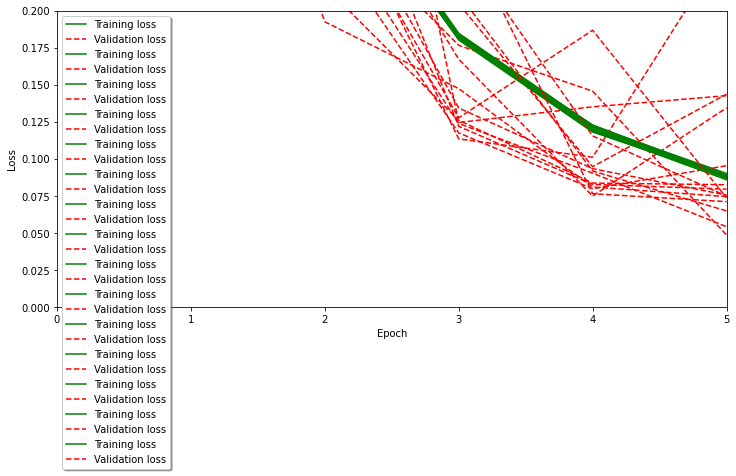

In [13]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
for i in range(nets):
    history=histories[i]
    epoch_range = 1 + np.arange(len(history.history['accuracy']))
    plt.plot(epoch_range,history.history['loss'],'g-',label='Training loss')
    plt.plot(epoch_range,history.history['val_loss'],'r--',label='Validation loss')
    plt.legend(loc='best',shadow=True)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xlim([0,epochs])
    plt.ylim([0,0.2])


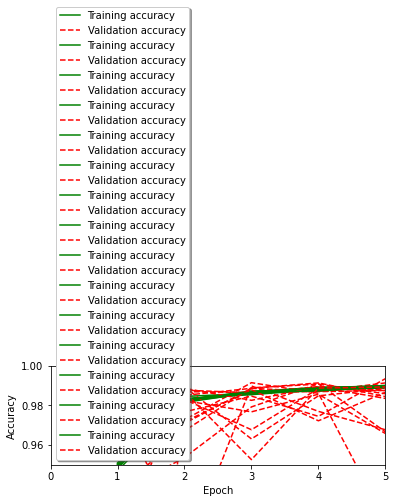

In [14]:
plt.subplot(2,1,2)
for i in range(nets):
    history=histories[i]
    epoch_range = 1 + np.arange(len(history.history['accuracy']))
    plt.plot(epoch_range,history.history['accuracy'],'g-',label='Training accuracy')
    plt.plot(epoch_range,history.history['val_accuracy'],'r--',label='Validation accuracy')
    plt.legend(loc='best',shadow=True)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xlim([0,epochs])
    plt.ylim([0.95,1])
plt.show()

In [15]:
def plot_confusion_matrix(cm,classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

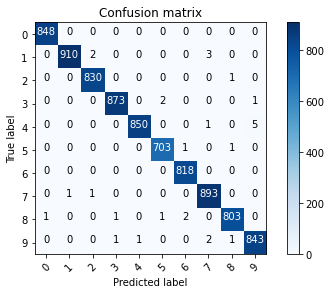

In [16]:
Y_pred = np.zeros_like(y_valid)
for i in range(nets):
    model = models[i]
    Y_pred += model.predict(x_valid,batch_size=128)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_valid,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(10))